In [ ]:

# Download the tf training file from https://drive.google.com/file/d/1NUltzZTqdYU9P_B12EDoIgqg1HU_lkE1/view?usp=drive_link
# !pip install gdown
# import gdown

In [ ]:
!gdown 1NUltzZTqdYU9P_B12EDoIgqg1HU_lkE1

Downloading...
From: https://drive.google.com/uc?id=1NUltzZTqdYU9P_B12EDoIgqg1HU_lkE1
To: /content/graph_opt_cmu.pb
100% 209M/209M [00:04<00:00, 49.1MB/s]


In [ ]:
import cv2 as cv
import numpy as np
# from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

In [ ]:


BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
               "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
               "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
               "LEye": 15, "REar": 16, "LEar": 17, "Background": 18, }

POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
               ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
               ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
               ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["LHip", "RHip"]]


width = 368
height = 368
inWidth = width
inHeight = height

net = cv.dnn.readNetFromTensorflow("graph_opt_cmu.pb")
thr = 0.2

def poseDetector(frame):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]

    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]  # MobileNet output [1, 57, -1, -1], we only need the first 19 elements

    assert(len(BODY_PARTS) == out.shape[1])

    points = []
    for i in range(len(BODY_PARTS)):
        # Slice heatmap of corresponging body's part.
        heatMap = out[0, i, :, :]

        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        points.append((int(x), int(y)) if conf > thr else None)

    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    t, _ = net.getPerfProfile()

    return frame

In [ ]:
img=cv.imread("image2.jpg")
imgg = cv.resize(img, None, fx = 0.5, fy = 0.5)

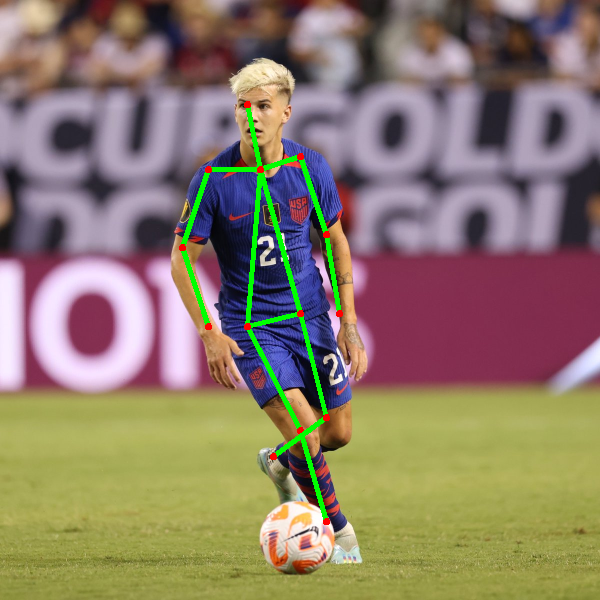

In [ ]:
output = poseDetector(imgg)
cv2_imshow(output)

In [ ]:
# export the output
cv.imwrite('pose.jpg', output)

True